# Goose Test Page (foraging areas, vegetation)

This is the first test page that is supposed to analyse the goose model data.<br>
First let us import the libraries and define the location of the data to analyse.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import time
import configparser, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import zlib
import lzma
import zipfile

In [2]:
data_dir = "rundir/"#"~/CLionProjects/GooseTests/run-directory1/"
source_dir = "ALMaSS_all" #"~/CLionProjects/ALMaSS_all"

In [3]:
# let us read the config data, it will be useful afterwards
CONFIG_PATH=data_dir+'TIALMaSSConfig.cfg'
with open(os.path.expanduser(CONFIG_PATH), 'r') as f:
    config_string = '[dummy_section]\n' + f.read()
config = configparser.ConfigParser(strict=False)
config.read_string(config_string)

In [4]:


# this is definition whether we take into account timed values or not
# Is there a reason to use not timed values
is_timed = True

species_names = ["barnacle", "greylag", "pinkfoot"]
geese_foods = ['grain', 'grass', 'maize']
geese_foods_wcereal = ['grain', 'grass', 'maize', 'cereal']
if is_timed==True:
    is_timed_str = '_timed'
else:
    is_timed_str = ''
    

# Let us define a mask that allows for all the fields to pass the filter if asterisk is used
# Here we assume that our data does not have asterisks, otherwise another symbol should be used
def ac_mask(df, key, value):
      if  value == '*':
          return df
      else:
          return df[df[key] == value] 
# The same mask as previously, but allows to merge the values together, uses pd.Series
# also faster than the previous one
def ac_mask_mult(df, key, value):
      if  value == '*':
          return df
      else:
          if not(isinstance(value, list)):
              value = [value]
          return df[pd.Series(df[key]).isin(value)]
          
# We will use this mask instead of a standard one
pd.DataFrame.mask = ac_mask_mult



In [5]:
simulation_start_date = dt.date(2009, 1, 1)# we should check again that this is a right date, probably should be read from somewhere
simulation_start_date_ordinal=dt.date.toordinal(simulation_start_date)

# Forage data first: load data , while stripping the spaces 
#forage_data=pd.read_csv(data_dir+"GooseFieldForageData.txt", sep='\t', header=0, parse_dates=['day'], dtype={'day': 'str'},date_parser=my_dateparser)
with zipfile.ZipFile(data_dir+"GooseFieldForageData.txt.gz", 'r') as zip_ref:
    zip_ref.extractall(data_dir)
forage_data=pd.read_csv(data_dir+"GooseFieldForageData.txt", sep='\t', header=0, dtype={'day': np.int16}, converters={'last_sown_veg': str.strip, 'veg_type_chr': str.strip, 'previous_crop': str.strip})
# The field dayordinal has the current day counting from 1/1/0001
forage_data['dayordinal']=forage_data['day']+simulation_start_date_ordinal
# Useful function that parses the data 
my_dateparser=(lambda x: pd.to_datetime(x,unit='D', origin=simulation_start_date))
# The field 'daydate includes the date of the day for the data'
forage_data['daydate']=my_dateparser(forage_data['day'])
forage_data['weekdate']=forage_data['daydate'].dt.strftime('%Y-W%U')
forage_data['habitat'] = 'Unknown'


## Foraging tests
The next cell defines the dictionary that "translates" from field type into predefined forage habitats

In [6]:
# A dictionary that will allow to map vegetation to habitat
# The value is a list of tuples of last_sown_veg, veg_phase, veg_type_chr, previous_crop
# asterisk means don't care
# The key is habitat (In current R file there different columns for each 
# species, but the resulting values are the same, so why?--> less code, less values is better)
veg_to_habitat_filt_keys=('last_sown_veg', 'veg_phase', 'veg_type_chr', 'previous_crop')

veg_to_habitat = {
    # Grasses: check that none is missing
    'Grass': [('PermanentGrassGrazed', [3,2,0], '*', '*'),
    ('PermanentGrassTussocky', [0,2], '*', '*'),
    ('CloverGrassGrazed1', [2,3], '*', '*'),
    ('CloverGrassGrazed2', 2, '*', '*'),
    ('OWinterWheatUndersown', 2, '*', '*'),
    ('OSeedGrass1', [3,2,0], '*', '*'),
    ('OSeedGrass2', [3,2,0], '*', '*'),
    ('SeedGrass2', [3,2,0], '*', '*'),
    ('SeedGrass1', [3,2,0], '*', '*'),
    ('OCloverGrassGrazed2', [0,2], '*', '*'),    
    ('OCloverGrassGrazed1', [0,2,3], '*', '*'), 
    ('CloverGrassGrazed1', 0, '*', '*'), 
    ('CloverGrassGrazed2', 0, '*', '*'),
    ('NaturalGrass', '*', '*', '*')],
    'Rape': [('WinterRape', [0,2,3], '*', '*')],
    'WinterCereal':[('SpringBarley', [0,1,2], '*', '*'),
                    ('WinterWheat', [0,1,2], '*', '*'),
                    ('OWinterWheat', [0,1,2], '*', '*'),
                    ('SprBarleyCloverGrass', [0,1,2], '*', '*'),
                    ('WinterRye', [0,1,2], '*','*'),
                    ('OBarleyPeaCloverGrass', [2,1,0], '*', '*'),
                    ('OWinterRye', [2,1,0], '*', '*'),
                    ('OSBarleySilage', [0,1,2], '*', '*'),
                    ('OCarrots', 1, '*', '*'),
                    ('OSpringBarley', [2,1,0], '*', '*'),
                    ('OTriticale', [0,1,2], '*', '*'),
                    ('WinterBarley', [0,1,2], '*', '*'),
                    ('Triticale', [0,1,2], '*', '*'),
                    ('SpringBarleySilage', [0,1,2], '*', '*'),
                    ('WinterRape', 1, '*', '*'),
                    ('OWinterWheatUndersown', [0,1], '*', '*'),
                    ('Undefined', 0, '*', '*'),
                    ('OOats', [0,1,2], '*', '*'),
                    ('Oats', [0,1,2], '*', '*'),
                    ('OFieldPeas', 0, '*', '*')],
    'Stubble': [(['WinterBarley', 'OBarleyPeaCloverGrass', 'SprBarleyCloverGrass', 
                  'SpringBarleySilage', 'OSBarleySilage', 'OWinterRye', 'WinterRye', 
                  'OSpringBarley', 'SpringBarley', 'WinterWheat', 'OWinterWheat', 'OOats', 
                  'Oats', 'OTriticale', 'OWinterWheatUndersown', 'Triticale', 'OFieldPeas'], 3, '*', '*'),
                (['CloverGrassGrazed1','SeedGrass1'], '*', '*', 'SprBarleyCloverGrass'),
                (['CloverGrassGrazed1','SeedGrass1'], '*', 'SprBarleyCloverGrass', '*'),
                ('CloverGrassGrazed1', '*', '*', 'SpringBarley')
        ],
    'Maize': [(['MaizeSilage','OMaizeSilage'], [0,1,2,3], '*', '*')
              ],
    'Undefined':[('Undefined', [2,3], '*', '*')]
    }
Cereals_list=[
'SpringBarley',
'SpringBarleySpr',
'WinterBarley',
'SpringWheat',
'WinterWheat',
'WinterRye',
'Oats',
'Triticale',
'SpringBarleySeed',
'SpringBarleyStrigling',
'SpringBarleyStriglingSingle',
'SpringBarleyStriglingCulm',
'WinterWheatStrigling',
'WinterWheatStriglingSingle',
'WinterWheatStriglingCulm',
'OWinterBarley',
'OWinterBarleyExt',
'OWinterRye',
'SpringBarleyGrass',
'SpringBarleyCloverGrass',
'SpringBarleyPeaCloverGrassStrigling',
'OSpringBarley',
'OSpringBarleyPigs',
'OWinterWheatUndersown',
'OWinterWheat',
'OOats',
'OTriticale',
'WWheatPControl',
'WWheatPToxicControl',
'WWheatPTreatment',
'AgroChemIndustryCereal',
'SpringBarleyPTreatment',
'SpringBarleySKManagement',
'OSpringBarleyExt',
'OSpringBarleyGrass',
'OSpringBarleyClover',
'PLWinterWheat',
'PLWinterBarley',
'PLWinterRye',
'PLWinterTriticale',
'PLSpringWheat',
'PLSpringBarley',
'NLWinterWheat',
'NLSpringBarley',
        ]


We will use this dictionary to filter and put the result in the column called habitat (Is it ever used?)

In [7]:
# let us combine the fields for testing
t = time.time()
for habitat_i in veg_to_habitat.keys():
    forage_data_idxx = [forage_data.mask(veg_to_habitat_filt_keys[0],t[0])
                        .mask(veg_to_habitat_filt_keys[1],t[1]).mask(veg_to_habitat_filt_keys[2],t[2])
                        .mask(veg_to_habitat_filt_keys[3],t[3]).index.values for t in veg_to_habitat[habitat_i]]
    idxs = np.concatenate(forage_data_idxx).ravel().tolist()

    forage_data.iloc[idxs, forage_data.columns.get_loc("habitat")] = habitat_i
elapsed = time.time() - t
print('Calculating new foraging habitats--> Elapsed: %s' % (elapsed))

Calculating new foraging habitats--> Elapsed: 6.296581745147705


Now we organize the data of feeding habitats

In [8]:


# now let us filter the table where the geese exist and the months are between august and march
t = time.time()
forage_data_months_filtered = forage_data[forage_data['geese'+is_timed_str]&((forage_data['daydate'].dt.month>7) | (forage_data['daydate'].dt.month<4))]

species_habs_to_plot = {new_list: {new_list1:pd.DataFrame() for new_list1 in geese_foods} for new_list in species_names}
for i in range(len(species_names)):
    for j in range(len(geese_foods)):
        # temporary view that holds the areas/times when species are bigger than 0
        temp = forage_data_months_filtered[species_names[i]+is_timed_str]>0
        if geese_foods[j] == 'grass':
            species_habs_to_plot[species_names[i]][geese_foods[j]] = pd.DataFrame({'Date': forage_data_months_filtered[temp]['daydate'], 
                                                                                   'FlockSize': forage_data_months_filtered[temp][species_names[i]+is_timed_str],
                                                                                   ' kJ/min': forage_data_months_filtered[temp]['grass_'+species_names[i]]})
        else:
            if geese_foods[j] == 'grain':
                title1 = ' gr/m^2'
            else:
                title1 = ' kJ/m^2'
            
            species_habs_to_plot[species_names[i]][geese_foods[j]] = pd.DataFrame({'Date': forage_data_months_filtered[temp]['daydate'], 
                                                                                   'FlockSize': forage_data_months_filtered[temp][species_names[i]+is_timed_str],
                                                                                   title1: forage_data_months_filtered[temp][geese_foods[j]]})
elapsed = time.time() - t
print('Filtering foraging data--> Elapsed: %s' % (elapsed))

Filtering foraging data--> Elapsed: 0.6277561187744141


and plot the results

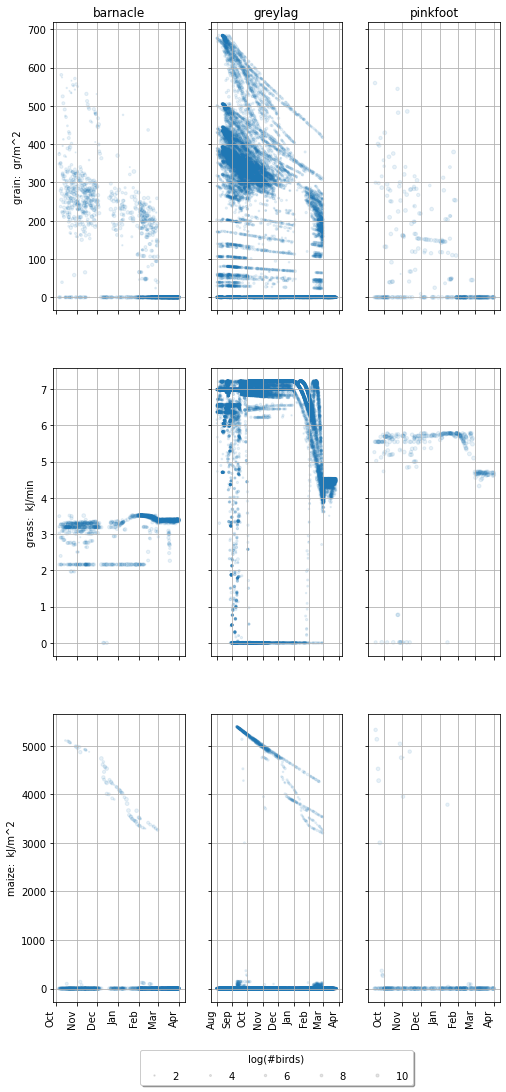

In [9]:


fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=mpl.figure.figaspect(2.5)*2)

months = mdates.MonthLocator()
myFmt = mdates.DateFormatter('%b')
# plt.sca()
fig.autofmt_xdate(rotation='vertical')
# fig.suptitle('Available forage on the fields with geese')
for i in range(3):
    for j in range(3):
        ax[i,j].xaxis.set_major_formatter(myFmt)
        
        ax[i,j].grid()
        
        
        ax[i,j].xaxis.set_minor_locator(months)
        ax[i,j].xaxis_date()
        
        line1=ax[i,j].scatter(x=species_habs_to_plot[species_names[j]][geese_foods[i]].iloc[:,0], 
                    y=species_habs_to_plot[species_names[j]][geese_foods[i]].iloc[:,2], alpha=0.1, 
                    s=np.log10(species_habs_to_plot[species_names[j]][geese_foods[i]].iloc[:,1])*4)
        if j == 0:
            ax[i,j].set_ylabel(geese_foods[i]+': '+species_habs_to_plot[species_names[j]][geese_foods[i]].columns.values[2])
        if i == 0:
            ax[i,j].set_title(species_names[j])
        if i ==2 and j ==1:
            ax[i,j].legend(*line1.legend_elements("sizes", num=6), loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=5, title='log(#birds)')
                



Note that the scale is completely different because for each forage source we compare different values. Available amount of maize is in kJ/m^2, amount of grass in maximum rate of consumption for each species and grain is in number of grain per sq meter. We can scale it up to the maximum consumption rate as it is done in the code and then look on the maximum value of grain/maize/grass in each location, trying to establish what exactly the geese are eating:

In [10]:
           
# default values for HollingDiskCurve for grain and maize (taken from source code)
param_A_grain = 0.04217666
param_B_grain = 0.0840075
param_A_maize = 0.04294186
param_B_maize = 0.05844966
# scaling parameters between the species (taken from source code)
grain_PF_to_GL = 1.21
grain_PF_to_BL = 0.74

maize_BL_to_GL = 1.64
maize_BL_to_PF = 1.35



# let us check whether defaults are not overridden in config file

param_A_grain=config.get('dummy_section', 'hollings_one_a (float)', fallback=param_A_grain)
param_B_grain=config.get('dummy_section', 'hollings_one_b (float)', fallback=param_B_grain)

param_A_maize=config.get('dummy_section', 'hollings_two_a (float)', fallback=param_A_maize)
param_B_maize=config.get('dummy_section', 'hollings_two_b (float)', fallback=param_B_maize)



Now we will plot the graphs of relationship between the food density and the foraging rate

Text(0.5, 0.98, 'Maize')

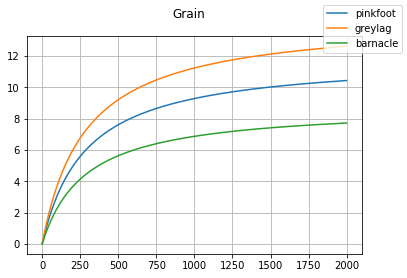

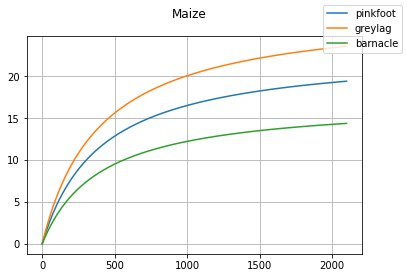

In [11]:
## Let us try grain
grain_availability=np.arange(start = 0, stop = 2000)

grain_intake_PF = (grain_availability * param_A_grain)/(1+param_A_grain*param_B_grain*grain_availability)
grain_intake_GL=grain_intake_PF* grain_PF_to_GL
grain_intake_BL=grain_intake_PF* grain_PF_to_BL
fig1, ax1 = plt.subplots()
p1,=ax1.plot(grain_availability, grain_intake_PF)
p2,=ax1.plot(grain_availability, grain_intake_GL)
p3,=ax1.plot(grain_availability, grain_intake_BL)
ax1.grid()

fig1.legend([p1,p2,p3],['pinkfoot', 'greylag', 'barnacle'])
fig1.suptitle('Grain')
#fig1.show()

## Let us try maize
maize_availability=np.arange(start = 0, stop = 2100)

maize_intake_BL = (maize_availability * param_A_maize)/(1+param_A_maize*param_B_maize*maize_availability)
maize_intake_GL=maize_intake_BL*  maize_BL_to_GL
maize_intake_PF=maize_intake_BL* maize_BL_to_PF
fig2, ax2 = plt.subplots()
p1,=ax2.plot(maize_availability, maize_intake_PF)
p2,=ax2.plot(maize_availability, maize_intake_GL)
p3,=ax2.plot(maize_availability, maize_intake_BL)
ax2.grid()

fig2.legend([p1,p2,p3],['pinkfoot', 'greylag', 'barnacle'])
fig2.suptitle('Maize')
#fig2.show()

In [12]:
# All seems fine, let us estimate the feeding rate
maize_intake_params={'paramA':param_A_maize, 'paramB':param_B_maize, 'BL_to_GL':maize_BL_to_GL, 'BL_to_PF':maize_BL_to_PF}
grain_intake_params={'paramA':param_A_grain, 'paramB':param_B_grain, 'PF_to_GL':grain_PF_to_GL, 'PF_to_BL':grain_PF_to_BL}
def calc_maize_intake(x, maize_intake_params, species_inp):
    if species_inp == 'barnacle':
        return (x * maize_intake_params['paramA'])/(1+maize_intake_params['paramA']*maize_intake_params['paramB']*x)
    elif species_inp == 'greylag':
        return (x * maize_intake_params['paramA'])/(1+maize_intake_params['paramA']*maize_intake_params['paramB']*x)*maize_intake_params['BL_to_GL']
    elif species_inp == 'pinkfoot':
        return (x * maize_intake_params['paramA'])/(1+maize_intake_params['paramA']*maize_intake_params['paramB']*x)*maize_intake_params['BL_to_PF']
def calc_grain_intake(x, grain_intake_params, species_inp):
    if species_inp == 'pinkfoot':
        return (x * grain_intake_params['paramA'])/(1+grain_intake_params['paramA']*grain_intake_params['paramB']*x)
    elif species_inp == 'barnacle':
        return (x * grain_intake_params['paramA'])/(1+grain_intake_params['paramA']*grain_intake_params['paramB']*x)*grain_intake_params['PF_to_BL']
    elif species_inp == 'greylag':
        return (x * grain_intake_params['paramA'])/(1+grain_intake_params['paramA']*grain_intake_params['paramB']*x)*grain_intake_params['PF_to_GL']

forage_data['maize_intake_barnacle'] = calc_maize_intake(forage_data['maize'], maize_intake_params, 'barnacle')
forage_data['maize_intake_pinkfoot'] = calc_maize_intake(forage_data['maize'], maize_intake_params, 'pinkfoot')
forage_data['maize_intake_greylag'] = calc_maize_intake(forage_data['maize'], maize_intake_params, 'greylag')



forage_data['grain_intake_barnacle'] = calc_grain_intake(forage_data['grain'], grain_intake_params, 'barnacle')
forage_data['grain_intake_pinkfoot'] = calc_grain_intake(forage_data['grain'], grain_intake_params, 'pinkfoot')
forage_data['grain_intake_greylag'] = calc_grain_intake(forage_data['grain'], grain_intake_params, 'greylag')

for i in species_names:
    forage_data['max_intake_'+i] = forage_data[['grain_intake_'+i,'grass_'+i,'maize_intake_'+i]].max(axis=1)
    ttemp = pd.DataFrame(data=forage_data[['grain_intake_'+i,'grass_'+i,'maize_intake_'+i]])
    ttemp.columns = geese_foods
    forage_data['max_intake_source_'+i] = ttemp.idxmax(axis=1)
    forage_data['max_intake_source_wcereal_'+i] =  forage_data['max_intake_source_'+i]
    # since when grass
    forage_data.loc[forage_data['veg_type_chr'].isin(Cereals_list) & (forage_data['max_intake_source_'+i]=='grass'),'max_intake_source_wcereal_'+i]='cereal'
del ttemp

forage_data_months_filtered = forage_data[forage_data['geese'+is_timed_str]&((forage_data['daydate'].dt.month>7) | (forage_data['daydate'].dt.month<4))]


In [13]:
t = time.time()

species_foods_to_plot = {new_list: {new_list1:pd.DataFrame() for new_list1 in geese_foods} for new_list in species_names}
for i in range(len(species_names)):
    for j in range(len(geese_foods)):
        # temporary view that holds the areas/times when species are bigger than 0
        temp = (forage_data_months_filtered[species_names[i]+is_timed_str]>0) & (forage_data_months_filtered['max_intake_source_'+species_names[i]]==geese_foods[j])
 
        species_foods_to_plot[species_names[i]][geese_foods[j]] = pd.DataFrame({'Date': forage_data_months_filtered[temp]['daydate'], 
                                                                                   'FlockSize': forage_data_months_filtered[temp][species_names[i]+is_timed_str],
                                                                                   ' kJ/min': forage_data_months_filtered[temp]['max_intake_'+species_names[i]]})
 
elapsed = time.time() - t
print('Filtering foraging data--> Elapsed: %s' % (elapsed))


Filtering foraging data--> Elapsed: 0.07705903053283691


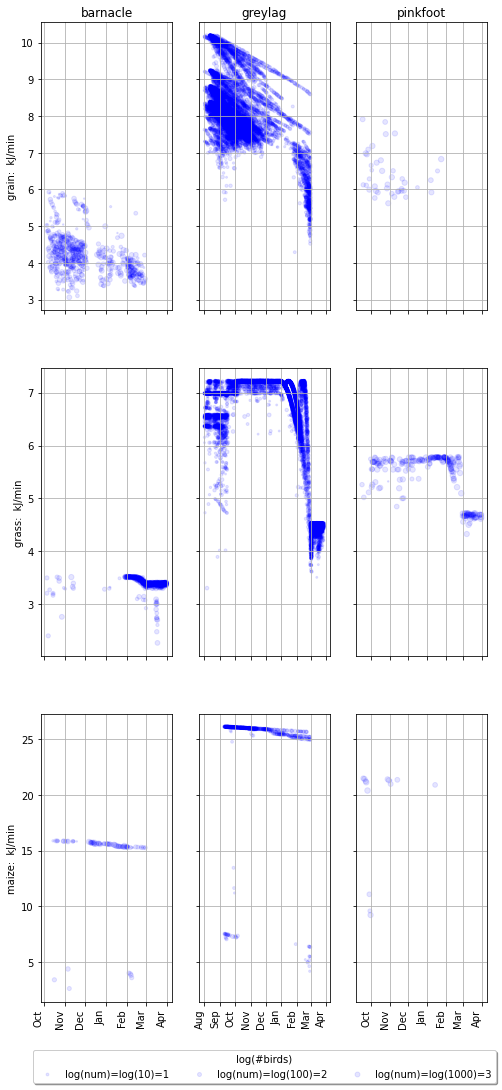

In [14]:

fig3, ax3 = plt.subplots(3, 3, sharex='col', sharey='row', figsize=mpl.figure.figaspect(2.5)*2)

months = mdates.MonthLocator()
myFmt = mdates.DateFormatter('%b')
# plt.sca()
fig3.autofmt_xdate(rotation='vertical')
# fig.suptitle('Available forage on the fields with geese')
for i in range(3):
    for j in range(3):
        ax3[i,j].xaxis.set_major_formatter(myFmt)
        
        ax3[i,j].grid()
        
        
        ax3[i,j].xaxis.set_minor_locator(months)
        ax3[i,j].xaxis_date()
        
        line1=ax3[i,j].scatter(x=species_foods_to_plot[species_names[j]][geese_foods[i]].iloc[:,0], 
                    y=species_foods_to_plot[species_names[j]][geese_foods[i]].iloc[:,2], alpha=0.1, 
                    s=np.log10(species_foods_to_plot[species_names[j]][geese_foods[i]].iloc[:,1])*8, color='blue')
        if j == 0:
            ax3[i,j].set_ylabel(geese_foods[i]+': '+species_foods_to_plot[species_names[j]][geese_foods[i]].columns.values[2])
        if i == 0:
            ax3[i,j].set_title(species_names[j])
        if i ==2 and j ==1:
            marker1 = ax3[i,j].scatter([],[], s=np.log10(10)*8, color='blue',alpha=0.1)
            marker2 = ax3[i,j].scatter([],[], s=np.log10(100)*8, color='blue',alpha=0.1)
            marker3 = ax3[i,j].scatter([],[], s=np.log10(1000)*8, color='blue',alpha=0.1)
            legend_markers = [marker1, marker2, marker3]

            labels1 = ["log(num)=log(10)=1","log(num)=log(100)=2","log(num)=log(1000)=3"]
            #ax[i,j].legend(*line1.legend_elements("sizes", num=6), loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=5, title='log(#birds)')
            ax3[i,j].legend(handles=legend_markers, labels=labels1, loc='upper center', scatterpoints=1,bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=5, title='log(#birds)')


This is available maximum consumption of food for each species on the field they are timed. Now the graphs united for each species.

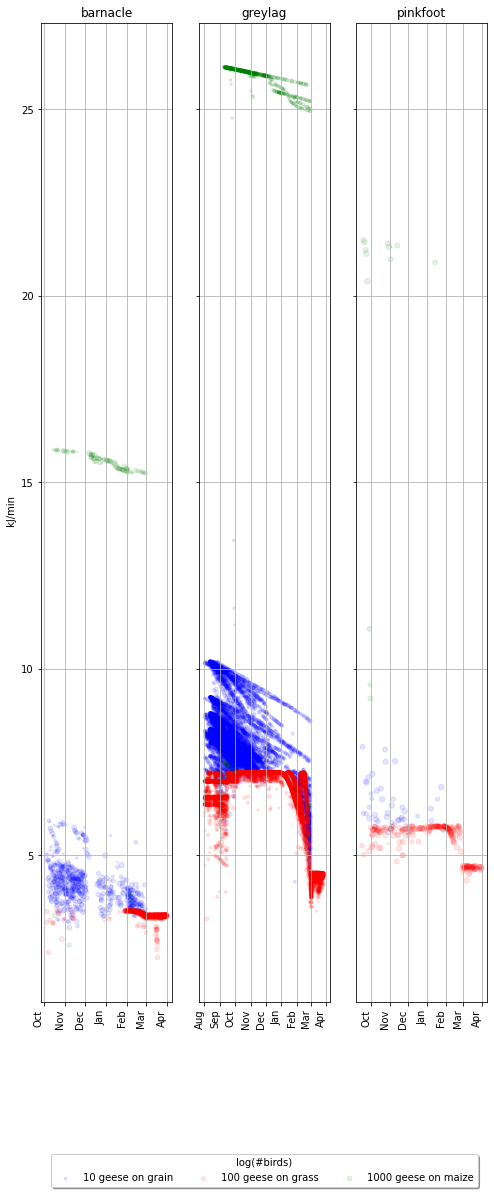

In [15]:
fig4, ax4 = plt.subplots(1, 3, sharex='col', sharey='row', figsize=mpl.figure.figaspect(2.5)*2)

months = mdates.MonthLocator()
myFmt = mdates.DateFormatter('%b')
# plt.sca()
fig4.autofmt_xdate(rotation='vertical')
colours = ['blue', 'red', 'green']
for i in range(3):
    for j in range(3):
        ax4[j].xaxis.set_major_formatter(myFmt)
        
        ax4[j].grid()
        
        
        ax4[j].xaxis.set_minor_locator(months)
        ax4[j].xaxis_date()
        
        line1=ax4[j].scatter(x=species_foods_to_plot[species_names[j]][geese_foods[i]].iloc[:,0], 
                    y=species_foods_to_plot[species_names[j]][geese_foods[i]].iloc[:,2], alpha=0.1, 
                    s=np.log10(species_foods_to_plot[species_names[j]][geese_foods[i]].iloc[:,1])*8, color=colours[i])
        if j == 0:
            ax4[j].set_ylabel(species_foods_to_plot[species_names[j]][geese_foods[i]].columns.values[2])
        if i == 0:
            ax4[j].set_title(species_names[j])
        if j ==1:
            marker1 = ax4[j].scatter([],[], s=np.log10(10)*8, color='blue',alpha=0.1)
            marker2 = ax4[j].scatter([],[], s=np.log10(100)*8, color='red',alpha=0.1)
            marker3 = ax4[j].scatter([],[], s=np.log10(1000)*8, color='green',alpha=0.1)
            legend_markers = [marker1, marker2, marker3]

            labels1 = ["10 geese on grain","100 geese on grass","1000 geese on maize"]
            #ax[i,j].legend(*line1.legend_elements("sizes", num=6), loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=5, title='log(#birds)')
            ax4[j].legend(handles=legend_markers, labels=labels1, loc='upper center', scatterpoints=1,bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=5, title='log(#birds)')


*It seems like they are feeding on grain for very long maybe it should decay faster? __How fast? What about maize, does it decay with the same rate as grain?__ Also, it may be that something else is present on the field and the geese are foraging grass on the field that there was spilled grain. In order to compare things we will try to show comparable use of the resources in each day. Here we assume that if the geese are on the field where the maximum foraging rate is the biggest for grass/grain/maize, all of them eat it. We will sum all the animals that eat this particular food each week and summarize it in the following graph.*

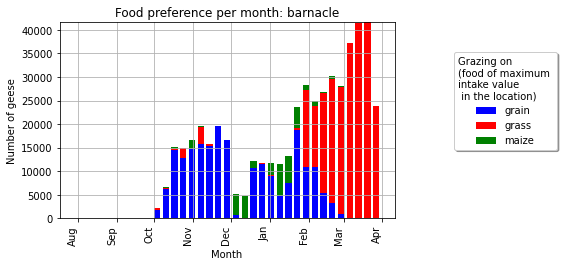

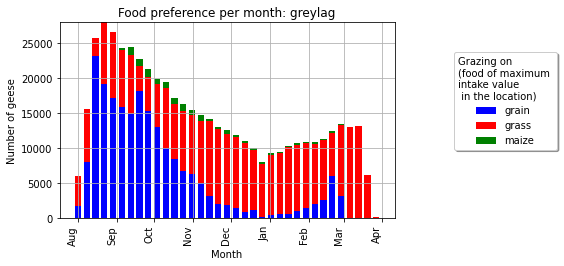

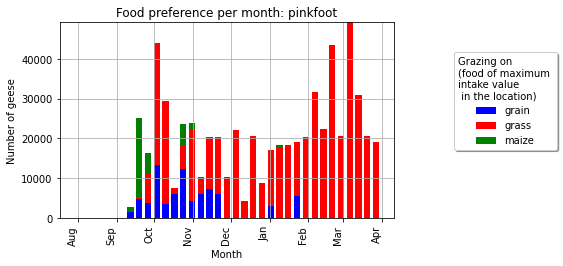

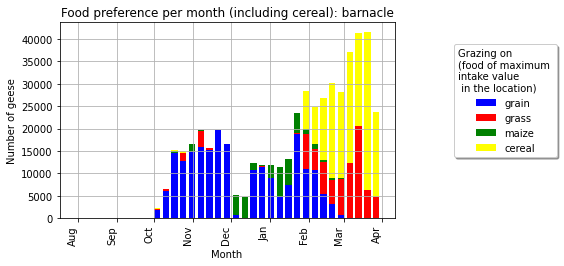

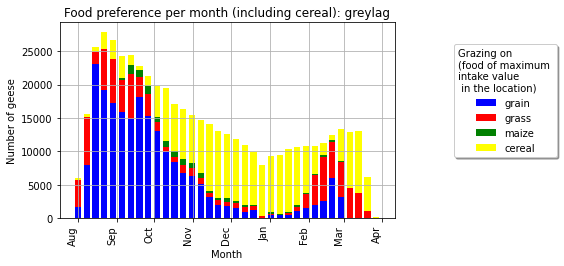

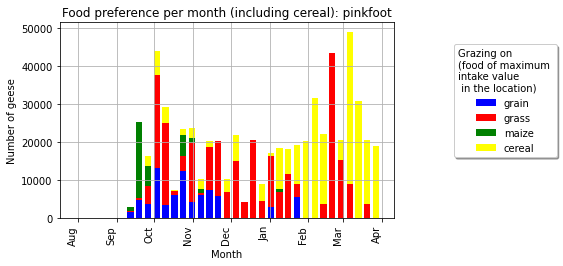

In [27]:
forage_summary=forage_data_months_filtered.groupby(['weekdate', 'max_intake_source_barnacle', 
                                                    'max_intake_source_greylag', 'max_intake_source_pinkfoot']).agg(
                                                        barnacle_sum=('barnacle'+is_timed_str, sum),greylag_sum=(
                                                            'greylag'+is_timed_str, sum),pinkfoot_sum=(
                                                                'pinkfoot'+is_timed_str, sum))
forage_summary_wcereal=forage_data_months_filtered.groupby(['weekdate', 'max_intake_source_wcereal_barnacle', 
                                                    'max_intake_source_wcereal_greylag', 'max_intake_source_wcereal_pinkfoot']).agg(
                                                        barnacle_sum=('barnacle'+is_timed_str, sum),greylag_sum=(
                                                            'greylag'+is_timed_str, sum),pinkfoot_sum=(
                                                                'pinkfoot'+is_timed_str, sum))
for j in range(3):
    fig4a, ax4a = plt.subplots()
    
    months = mdates.MonthLocator()
    myFmt = mdates.DateFormatter('%b')
    # plt.sca()
    fig4a.autofmt_xdate(rotation='vertical')
    colours = ['blue', 'red', 'green']
    width = 5
    all_dates_str =  forage_summary.index.get_level_values(0).unique()
    #all_dates=[pendulum.parse(i) for i in all_dates_str]
    all_dates=[dt.datetime.strptime(i+'-0', '%Y-W%U-%w') for i in all_dates_str]
    ax4a.xaxis.set_major_formatter(myFmt)
        
    ax4a.grid()
        
        
    ax4a.xaxis.set_minor_locator(months)
    ax4a.xaxis_date()
    grain_t=forage_summary.xs('grain', level=1+j)[species_names[j]+'_sum'].reset_index(level=2, drop=True).reset_index(level=1, drop=True).groupby(level=0).agg(sum).reindex(all_dates_str).fillna(0)
    grass_t=forage_summary.xs('grass', level=1+j)[species_names[j]+'_sum'].reset_index(level=2, drop=True).reset_index(level=1, drop=True).groupby(level=0).agg(sum).reindex(all_dates_str).fillna(0)
    maize_t=forage_summary.xs('maize', level=1+j)[species_names[j]+'_sum'].reset_index(level=2, drop=True).reset_index(level=1, drop=True).groupby(level=0).agg(sum).reindex(all_dates_str).fillna(0)
    p1=ax4a.bar(all_dates, grain_t, width, color=colours[0])
    p2=ax4a.bar(all_dates, grass_t, width, bottom=grain_t,color=colours[1])
    p3=ax4a.bar(all_dates, maize_t, width, bottom=grain_t+grass_t,color=colours[2])
    ax4a.set_title('Food preference per month: '+species_names[j])
    ax4a.legend(handles=(p1[0],p2[0],p3[0]),labels=geese_foods, fancybox=True, shadow=True, title='Grazing on\n(food of maximum \nintake value\n in the location)', loc='center right',bbox_to_anchor=(1.5, 0.60), ncol=1)
    ax4a.set_ylabel('Number of geese')
    ax4a.set_xlabel('Month')
    
for j in range(3):
    fig4a, ax4a = plt.subplots()
    
    months = mdates.MonthLocator()
    myFmt = mdates.DateFormatter('%b')
    # plt.sca()
    fig4a.autofmt_xdate(rotation='vertical')
    colours = ['blue', 'red', 'green', 'yellow']
    width = 5
    all_dates_str =  forage_summary_wcereal.index.get_level_values(0).unique()
    #all_dates=[pendulum.parse(i) for i in all_dates_str]
    all_dates=[dt.datetime.strptime(i+'-0', '%Y-W%U-%w') for i in all_dates_str]
    ax4a.xaxis.set_major_formatter(myFmt)
        
    ax4a.grid()
        
        
    ax4a.xaxis.set_minor_locator(months)
    ax4a.xaxis_date()
    grain_t=forage_summary_wcereal.xs('grain', level=1+j)[species_names[j]+'_sum'].reset_index(level=2, drop=True).reset_index(level=1, drop=True).groupby(level=0).agg(sum).reindex(all_dates_str).fillna(0)
    grass_t=forage_summary_wcereal.xs('grass', level=1+j)[species_names[j]+'_sum'].reset_index(level=2, drop=True).reset_index(level=1, drop=True).groupby(level=0).agg(sum).reindex(all_dates_str).fillna(0)
    maize_t=forage_summary_wcereal.xs('maize', level=1+j)[species_names[j]+'_sum'].reset_index(level=2, drop=True).reset_index(level=1, drop=True).groupby(level=0).agg(sum).reindex(all_dates_str).fillna(0)
    cereal_t=forage_summary_wcereal.xs('cereal', level=1+j)[species_names[j]+'_sum'].reset_index(level=2, drop=True).reset_index(level=1, drop=True).groupby(level=0).agg(sum).reindex(all_dates_str).fillna(0)
    p1=ax4a.bar(all_dates, grain_t, width, color=colours[0])
    p2=ax4a.bar(all_dates, grass_t, width, bottom=grain_t,color=colours[1])
    p3=ax4a.bar(all_dates, maize_t, width, bottom=grain_t+grass_t,color=colours[2])
    p4=ax4a.bar(all_dates, cereal_t, width, bottom=grain_t+grass_t+maize_t,color=colours[3])
    ax4a.set_title('Food preference per month (including cereal): '+species_names[j])
    ax4a.legend(handles=(p1[0],p2[0],p3[0], p4[0]),labels=geese_foods_wcereal, fancybox=True, shadow=True, title='Grazing on\n(food of maximum \nintake value\n in the location)', loc='center right',bbox_to_anchor=(1.5, 0.60), ncol=1)
    ax4a.set_ylabel('Number of geese')
    ax4a.set_xlabel('Month')

## Vegetation
### Vegetation heights for grasses

In [17]:
#### vegetation heights graphs
barnacle_max = 13.4626
pinkfoot_max = 16.6134
greylag_max = 24.3769

veg_types = forage_data['veg_type_chr'].unique()
regexp = re.compile(".*[gG]rass.*") # everything that contains grass
grass_types = list(filter(regexp.match, veg_types))
# let us filter grasses: All grasses
forage_data_grass = forage_data[forage_data['veg_type_chr'].isin(grass_types)]
grass_1=forage_data_grass.groupby(['veg_type_chr', 'daydate']).agg(veg_mean=('veg_height', np.mean), veg_std=('veg_height',np.std))
grass_1['veg_up']=grass_1['veg_mean']+grass_1['veg_std']
grass_1['veg_down']=grass_1['veg_mean']-grass_1['veg_std']
# let us filter grasses: those fields that geese are foraging upon
veg_types1 = forage_data_months_filtered['veg_type_chr'].unique()

grass_types_foraged = list(filter(regexp.match, veg_types1))
forage_data_grass2 = forage_data_months_filtered[forage_data_months_filtered['veg_type_chr'].isin(grass_types_foraged)]
grass_2=forage_data_grass2.groupby(['veg_type_chr', 'daydate']).agg(veg_mean=('veg_height', np.mean), veg_std=('veg_height',np.std))
grass_2['veg_up']=grass_2['veg_mean']+grass_2['veg_std']
grass_2['veg_down']=grass_2['veg_mean']-grass_2['veg_std']

# Now we filter fields where the geese are foraging and the grass has the max intake value
# thus it is probably foraged
forage_data_grass3 = forage_data_months_filtered[forage_data_months_filtered['veg_type_chr'].isin(grass_types_foraged) &((forage_data_months_filtered['barnacle_timed']>0) & (forage_data_months_filtered['max_intake_source_barnacle'] == 'grass') | (forage_data_months_filtered['pinkfoot_timed']>0) & (forage_data_months_filtered['max_intake_source_pinkfoot'] == 'grass') | (forage_data_months_filtered['greylag_timed']>0) & (forage_data_months_filtered['max_intake_source_greylag'] == 'grass'))]
veg_types3 = forage_data_grass3['veg_type_chr'].unique()
grass_3=forage_data_grass3.groupby(['veg_type_chr', 'daydate']).agg(veg_mean=('veg_height', np.mean), veg_std=('veg_height',np.std))
grass_3['veg_up']=grass_3['veg_mean']+grass_3['veg_std']
grass_3['veg_down']=grass_3['veg_mean']-grass_3['veg_std']

Total vegetation in the simulation

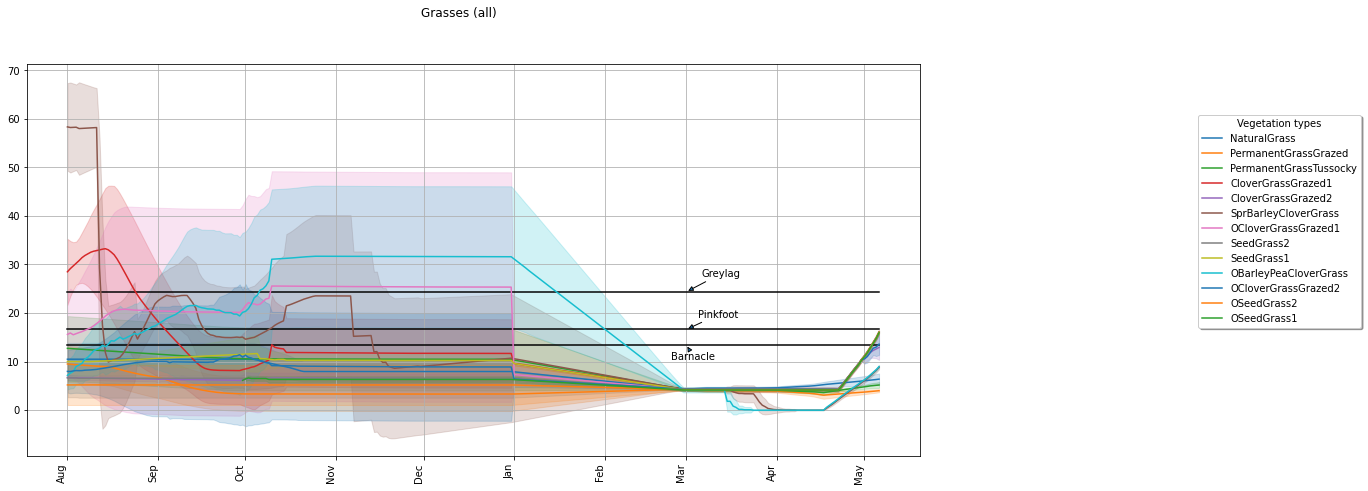

In [18]:
fig5, ax5 = plt.subplots(figsize=mpl.figure.figaspect(0.5)*2)

months = mdates.MonthLocator()
myFmt = mdates.DateFormatter('%b')
# plt.sca()
fig5.autofmt_xdate(rotation='vertical')
ax5.xaxis.set_major_formatter(myFmt)

ax5.grid()
p1=[None]*len(grass_types)

ax5.xaxis.set_minor_locator(months)
ax5.xaxis_date()
p=[None]*len(grass_types)
ax5.plot(grass_1.loc[(grass_types[1],)].index,barnacle_max*np.ones(len(grass_1.loc[(grass_types[1],)].index)), color='black')
ax5.plot(grass_1.loc[(grass_types[1],)].index,pinkfoot_max*np.ones(len(grass_1.loc[(grass_types[1],)].index)), color='black')
ax5.plot(grass_1.loc[(grass_types[1],)].index,greylag_max*np.ones(len(grass_1.loc[(grass_types[1],)].index)), color='black')
ax5.annotate('Barnacle', (mdates.date2num(dt.datetime(2011, 3, 1)), barnacle_max), xytext=(-15, -15), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax5.annotate('Pinkfoot', (mdates.date2num(dt.datetime(2011, 3, 1)), pinkfoot_max), xytext=(12, 12), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax5.annotate('Greylag', (mdates.date2num(dt.datetime(2011, 3, 1)), greylag_max), xytext=(15, 15), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
for i in range(len(grass_types)):
    
    p[i],=ax5.plot(grass_1.loc[(grass_types[i],)].index, grass_1.loc[(grass_types[i],)]['veg_mean'])
    p1[i]=ax5.fill_between(grass_1.loc[(grass_types[i],)].index, grass_1.loc[(grass_types[i],)]['veg_up'], grass_1.loc[(grass_types[i],)]['veg_down'],alpha=0.2,color=p[i]._color)
    #
fig5.suptitle('Grasses (all)')
ax5.legend(handles=p, labels=grass_types, fancybox=True, shadow=True, title='Vegetation types', loc='center right',bbox_to_anchor=(1.5, 0.60))


Vegetation that has been foraged (only fields that geese were upon are counted):

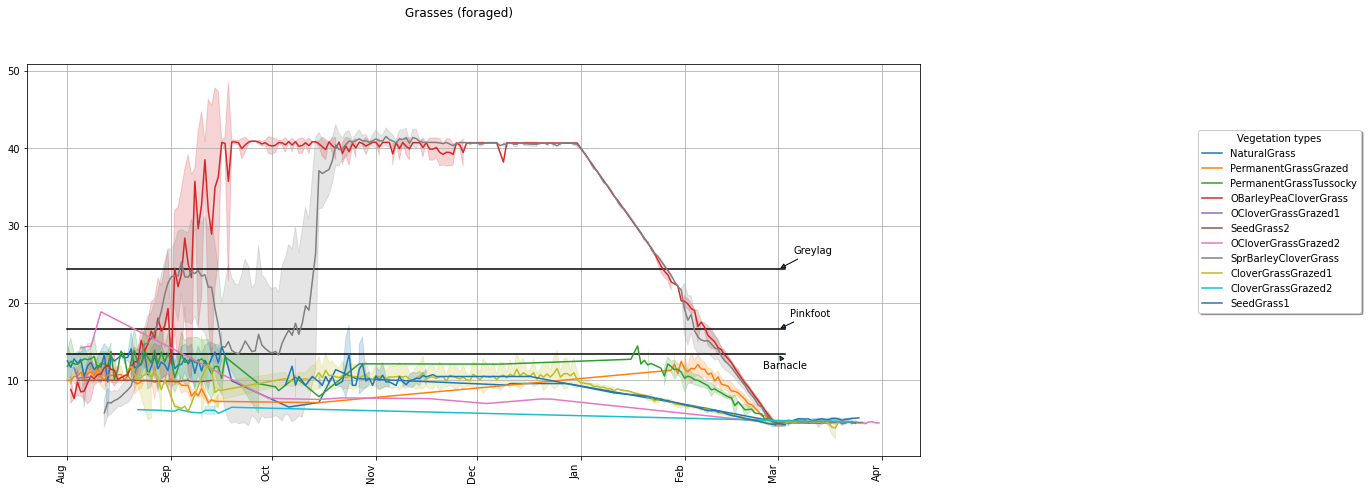

In [19]:
fig6, ax6 = plt.subplots(figsize=mpl.figure.figaspect(0.5)*2)

months = mdates.MonthLocator()
myFmt = mdates.DateFormatter('%b')
# plt.sca()
fig6.autofmt_xdate(rotation='vertical')
ax6.xaxis.set_major_formatter(myFmt)

ax6.grid()
p1=[None]*len(grass_types_foraged)

ax6.xaxis.set_minor_locator(months)
ax6.xaxis_date()
p_foraged=[None]*len(grass_types_foraged)
p1_foraged=[None]*len(grass_types_foraged)
ax6.plot(grass_2.loc[(grass_types_foraged[1],)].index,barnacle_max*np.ones(len(grass_2.loc[(grass_types_foraged[1],)].index)), color='black')
ax6.plot(grass_2.loc[(grass_types_foraged[1],)].index,pinkfoot_max*np.ones(len(grass_2.loc[(grass_types_foraged[1],)].index)), color='black')
ax6.plot(grass_2.loc[(grass_types_foraged[1],)].index,greylag_max*np.ones(len(grass_2.loc[(grass_types_foraged[1],)].index)), color='black')
ax6.annotate('Barnacle', (mdates.date2num(dt.datetime(2011, 3, 1)), barnacle_max), xytext=(-15, -15), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax6.annotate('Pinkfoot', (mdates.date2num(dt.datetime(2011, 3, 1)), pinkfoot_max), xytext=(12, 12), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax6.annotate('Greylag', (mdates.date2num(dt.datetime(2011, 3, 1)), greylag_max), xytext=(15, 15), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
for i in range(len(grass_types_foraged)):
    
    p_foraged[i],=ax6.plot(grass_2.loc[(grass_types_foraged[i],)].index, grass_2.loc[(grass_types_foraged[i],)]['veg_mean'])
    p1_foraged[i]=ax6.fill_between(grass_2.loc[(grass_types_foraged[i],)].index, grass_2.loc[(grass_types_foraged[i],)]['veg_up'], grass_2.loc[(grass_types_foraged[i],)]['veg_down'],alpha=0.2,color=p[i]._color)
    #
fig6.suptitle('Grasses (foraged)')
ax6.legend(handles=p_foraged, labels=grass_types_foraged, fancybox=True, shadow=True, title='Vegetation types', loc='center right',bbox_to_anchor=(1.5, 0.60))


*Here we can see that still some of the vegetation is higher than maximum accepted by the geese. What are they doing there? Foraging grain or maize? Let's check. We will filter the areas where the grass has the highest intake value and plot only these.*

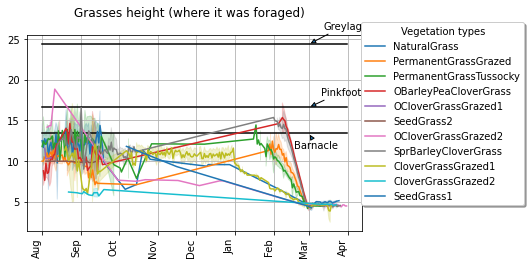

In [20]:

fig6a, ax6a = plt.subplots()

months = mdates.MonthLocator()
myFmt = mdates.DateFormatter('%b')
# plt.sca()
fig6a.autofmt_xdate(rotation='vertical')
ax6a.xaxis.set_major_formatter(myFmt)

ax6a.grid()


ax6a.xaxis.set_minor_locator(months)
ax6a.xaxis_date()
p_foraged=[None]*len(veg_types3)
p1_foraged=[None]*len(veg_types3)
start = grass_3.index.get_level_values(1).min()
end = grass_3.index.get_level_values(1).max()
t = np.linspace(start.value, end.value, 100)
t = pd.to_datetime(t)

ax6a.plot(t,barnacle_max*np.ones(len(t)), color='black')
ax6a.plot(t,pinkfoot_max*np.ones(len(t)), color='black')
ax6a.plot(t,greylag_max*np.ones(len(t)), color='black')
ax6a.annotate('Barnacle', (mdates.date2num(dt.datetime(2011, 3, 1)), barnacle_max), xytext=(-15, -15), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax6a.annotate('Pinkfoot', (mdates.date2num(dt.datetime(2011, 3, 1)), pinkfoot_max), xytext=(12, 12), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax6a.annotate('Greylag', (mdates.date2num(dt.datetime(2011, 3, 1)), greylag_max), xytext=(15, 15), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
for i in range(len(veg_types3)):
    
    p_foraged[i],=ax6a.plot(grass_3.loc[(veg_types3[i],)].index, grass_3.loc[(veg_types3[i],)]['veg_mean'])
    p1_foraged[i]=ax6a.fill_between(grass_3.loc[(veg_types3[i],)].index, grass_3.loc[(veg_types3[i],)]['veg_up'], grass_3.loc[(veg_types3[i],)]['veg_down'],alpha=0.2,color=p[i]._color)
    #
fig6a.suptitle('Grasses height (where it was foraged)')
ax6a.legend(handles=p_foraged, labels=list(veg_types3), fancybox=True, shadow=True, title='Vegetation types', loc='center right',bbox_to_anchor=(1.5, 0.60))


*All seems to be normal. This graph shows that when the geese are actually foraging grass, they do it in the areas where the grass height permits them to do that.*

## Non-grassy vegetation

In [21]:
regexp = re.compile("^((?![gG]rass).)*$") # everything that does not contain grass
nongrass_types = list(filter(regexp.match, veg_types))
# let us filter grasses: All non-grasses
forage_data_nongrass = forage_data[forage_data['veg_type_chr'].isin(nongrass_types)]
nongrass_1=forage_data_nongrass.groupby(['veg_type_chr', 'daydate']).agg(veg_mean=('veg_height', np.mean), veg_std=('veg_height',np.std))
nongrass_1['veg_up']=nongrass_1['veg_mean']+nongrass_1['veg_std']
nongrass_1['veg_down']=nongrass_1['veg_mean']-nongrass_1['veg_std']
# let us filter non-grasses: those that geese are foraging upon


nongrass_types_foraged = list(filter(regexp.match, veg_types1))
forage_data_nongrass2 = forage_data_months_filtered[forage_data_months_filtered['veg_type_chr'].isin(nongrass_types_foraged)]
nongrass_2=forage_data_nongrass2.groupby(['veg_type_chr', 'daydate']).agg(veg_mean=('veg_height', np.mean), veg_std=('veg_height',np.std))
nongrass_2['veg_up']=nongrass_2['veg_mean']+nongrass_2['veg_std']
nongrass_2['veg_down']=nongrass_2['veg_mean']-nongrass_2['veg_std']

# Filtering the fields where the geese are and where the grass us preferred food

nongrass_types_foraged = list(filter(regexp.match, veg_types1))
forage_data_nongrass3 = forage_data_months_filtered[forage_data_months_filtered['veg_type_chr'].isin(nongrass_types_foraged) &((forage_data_months_filtered['barnacle_timed']>0) & (forage_data_months_filtered['max_intake_source_barnacle'] == 'grass') | (forage_data_months_filtered['pinkfoot_timed']>0) & (forage_data_months_filtered['max_intake_source_pinkfoot'] == 'grass') | (forage_data_months_filtered['greylag_timed']>0) & (forage_data_months_filtered['max_intake_source_greylag'] == 'grass'))]
veg_types3 = forage_data_nongrass3['veg_type_chr'].unique()
nongrass_3=forage_data_nongrass3.groupby(['veg_type_chr', 'daydate']).agg(veg_mean=('veg_height', np.mean), veg_std=('veg_height',np.std))
nongrass_3['veg_up']=nongrass_3['veg_mean']+nongrass_3['veg_std']
nongrass_3['veg_down']=nongrass_3['veg_mean']-nongrass_3['veg_std']

All fields considered

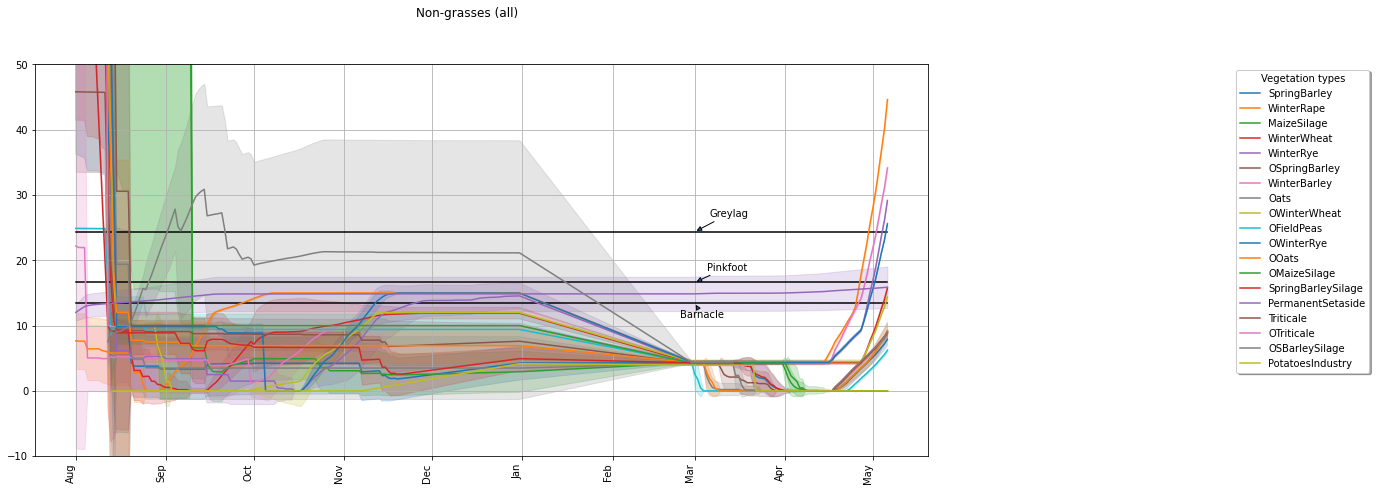

In [22]:

fig7, ax7 = plt.subplots(figsize=mpl.figure.figaspect(0.5)*2)

months = mdates.MonthLocator()
myFmt = mdates.DateFormatter('%b')
# plt.sca()
fig7.autofmt_xdate(rotation='vertical')
ax7.xaxis.set_major_formatter(myFmt)
ax7.set_ylim(-10,50)
ax7.grid()
p1=[None]*len(nongrass_types)

ax7.xaxis.set_minor_locator(months)
ax7.xaxis_date()
p=[None]*len(nongrass_types)
ax7.plot(nongrass_1.loc[(nongrass_types[1],)].index,barnacle_max*np.ones(len(nongrass_1.loc[(nongrass_types[1],)].index)), color='black')
ax7.plot(nongrass_1.loc[(nongrass_types[1],)].index,pinkfoot_max*np.ones(len(nongrass_1.loc[(nongrass_types[1],)].index)), color='black')
ax7.plot(nongrass_1.loc[(nongrass_types[1],)].index,greylag_max*np.ones(len(nongrass_1.loc[(nongrass_types[1],)].index)), color='black')
ax7.annotate('Barnacle', (mdates.date2num(dt.datetime(2011, 3, 1)), barnacle_max), xytext=(-15, -15), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax7.annotate('Pinkfoot', (mdates.date2num(dt.datetime(2011, 3, 1)), pinkfoot_max), xytext=(12, 12), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax7.annotate('Greylag', (mdates.date2num(dt.datetime(2011, 3, 1)), greylag_max), xytext=(15, 15), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
for i in range(len(nongrass_types)):
    
    p[i],=ax7.plot(nongrass_1.loc[(nongrass_types[i],)].index, nongrass_1.loc[(nongrass_types[i],)]['veg_mean'])
    p1[i]=ax7.fill_between(nongrass_1.loc[(nongrass_types[i],)].index, nongrass_1.loc[(nongrass_types[i],)]['veg_up'], nongrass_1.loc[(nongrass_types[i],)]['veg_down'],alpha=0.2,color=p[i]._color)
    #
fig7.suptitle('Non-grasses (all)')
ax7.legend(handles=p, labels=nongrass_types, fancybox=True, shadow=True, title='Vegetation types', loc='center right',bbox_to_anchor=(1.5, 0.60))


Only fields with geese upon were counted

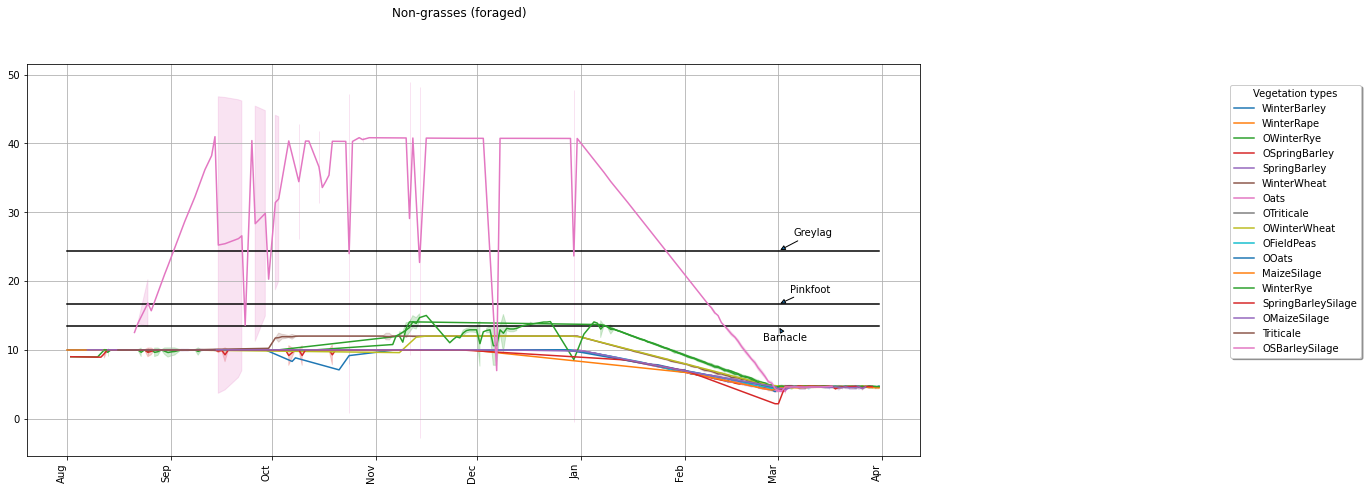

In [23]:
fig8, ax8 = plt.subplots(figsize=mpl.figure.figaspect(0.5)*2)

months = mdates.MonthLocator()
myFmt = mdates.DateFormatter('%b')
# plt.sca()
fig8.autofmt_xdate(rotation='vertical')
ax8.xaxis.set_major_formatter(myFmt)

ax8.grid()
p1=[None]*len(nongrass_types_foraged)

ax8.xaxis.set_minor_locator(months)
ax8.xaxis_date()
p_foraged=[None]*len(nongrass_types_foraged)
p1_foraged=[None]*len(nongrass_types_foraged)
start = nongrass_2.index.get_level_values(1).min()
end = nongrass_2.index.get_level_values(1).max()
t = np.linspace(start.value, end.value, 100)
t = pd.to_datetime(t)
ax8.plot(t,barnacle_max*np.ones(len(t)), color='black')
ax8.plot(t,pinkfoot_max*np.ones(len(t)), color='black')
ax8.plot(t,greylag_max*np.ones(len(t)), color='black')
ax8.annotate('Barnacle', (mdates.date2num(dt.datetime(2011, 3, 1)), barnacle_max), xytext=(-15, -15), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax8.annotate('Pinkfoot', (mdates.date2num(dt.datetime(2011, 3, 1)), pinkfoot_max), xytext=(12, 12), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax8.annotate('Greylag', (mdates.date2num(dt.datetime(2011, 3, 1)), greylag_max), xytext=(15, 15), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
for i in range(len(nongrass_types_foraged)):
    
    p_foraged[i],=ax8.plot(nongrass_2.loc[(nongrass_types_foraged[i],)].index, nongrass_2.loc[(nongrass_types_foraged[i],)]['veg_mean'])
    p1_foraged[i]=ax8.fill_between(nongrass_2.loc[(nongrass_types_foraged[i],)].index, nongrass_2.loc[(nongrass_types_foraged[i],)]['veg_up'], nongrass_2.loc[(nongrass_types_foraged[i],)]['veg_down'],alpha=0.2,color=p[i]._color)
    #
fig8.suptitle('Non-grasses (foraged)')
ax8.legend(handles=p_foraged, labels=nongrass_types_foraged, fancybox=True, shadow=True, title='Vegetation types', loc='center right',bbox_to_anchor=(1.5, 0.60))



*The same situation here. There are still areas where geese are walking in the vegetation which is too high for them. Let us investigate whether they are not eating something else.*

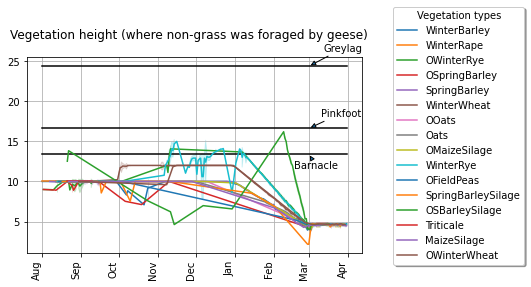

In [24]:
fig8a, ax8a = plt.subplots()

months = mdates.MonthLocator()
myFmt = mdates.DateFormatter('%b')
# plt.sca()
fig8a.autofmt_xdate(rotation='vertical')
ax8a.xaxis.set_major_formatter(myFmt)

ax8a.grid()

ax8a.xaxis.set_minor_locator(months)
ax8a.xaxis_date()
p_foraged=[None]*len(veg_types3)
p1_foraged=[None]*len(veg_types3)
start = nongrass_3.index.get_level_values(1).min()
end = nongrass_3.index.get_level_values(1).max()
t = np.linspace(start.value, end.value, 100)
t = pd.to_datetime(t)

ax8a.plot(t,barnacle_max*np.ones(len(t)), color='black')
ax8a.plot(t,pinkfoot_max*np.ones(len(t)), color='black')
ax8a.plot(t,greylag_max*np.ones(len(t)), color='black')
ax8a.annotate('Barnacle', (mdates.date2num(dt.datetime(2011, 3, 1)), barnacle_max), xytext=(-15, -15), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax8a.annotate('Pinkfoot', (mdates.date2num(dt.datetime(2011, 3, 1)), pinkfoot_max), xytext=(12, 12), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax8a.annotate('Greylag', (mdates.date2num(dt.datetime(2011, 3, 1)), greylag_max), xytext=(15, 15), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
for i in range(len(veg_types3)):
    
    p_foraged[i],=ax8a.plot(nongrass_3.loc[(veg_types3[i],)].index, nongrass_3.loc[(veg_types3[i],)]['veg_mean'])
    p1_foraged[i]=ax8a.fill_between(nongrass_3.loc[(veg_types3[i],)].index, nongrass_3.loc[(veg_types3[i],)]['veg_up'], nongrass_3.loc[(veg_types3[i],)]['veg_down'],alpha=0.2,color=p[i]._color)
    #
fig8a.suptitle('Vegetation height (where non-grass was foraged by geese)')
ax8a.legend(handles=p_foraged, labels=list(veg_types3), fancybox=True, shadow=True, title='Vegetation types', loc='center right',bbox_to_anchor=(1.5, 0.60))


*Also here all seems to be normal*

### Daily number of flocks

Text(0.5, 0.98, 'Daily flocks number')

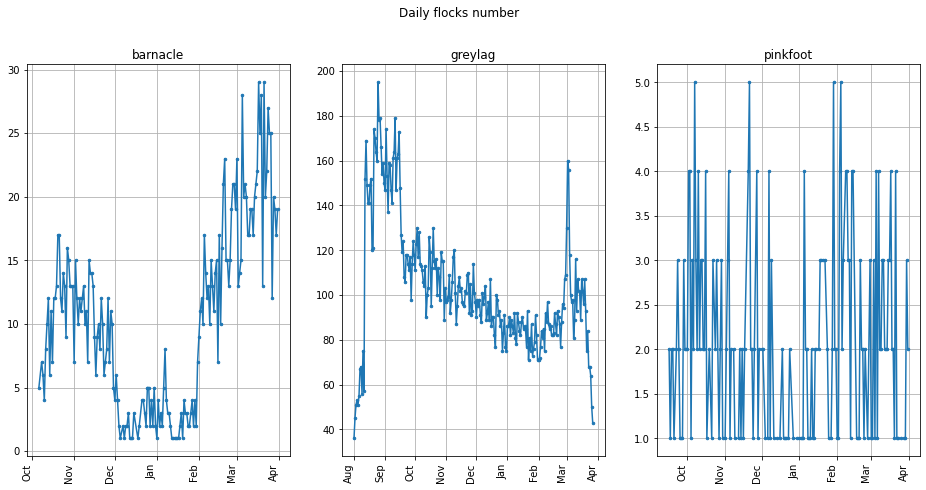

In [25]:
# Flocks stats
# we need forage data for this graph:
#forage_data=pd.read_csv(data_dir+"GooseFieldForageData.txt", sep='\t', header=0, dtype={'day': np.int16}, converters={'last_sown_veg': str.strip, 'veg_type_chr': str.strip, 'previous_crop': str.strip})
# The field dayordinal has the current day counting from 1/1/0001
#forage_data['dayordinal']=forage_data['day']+simulation_start_date_ordinal
# Useful function that parses the data 
#my_dateparser=(lambda x: pd.to_datetime(x,unit='D', origin=simulation_start_date))
# The field 'daydate includes the date of the day for the data'
#forage_data['daydate']=my_dateparser(forage_data['day'])
#forage_data['weekdate']=forage_data['daydate'].dt.strftime('%Y-W%U')
#forage_data_months_filtered = forage_data[forage_data['geese'+is_timed_str]&((forage_data['daydate'].dt.month>7) | (forage_data['daydate'].dt.month<4))]
fig15, ax15 = plt.subplots(1,3,figsize=mpl.figure.figaspect(0.5)*2)
months = mdates.MonthLocator()
myFmt = mdates.DateFormatter('%b')
fig15.autofmt_xdate(rotation='vertical')

for i in range(3):
    ax15[i].xaxis.set_major_formatter(myFmt)
    ax15[i].xaxis.set_minor_locator(months)
    ax15[i].xaxis_date()
    ax15[i].grid()
    temp=forage_data_months_filtered[forage_data_months_filtered[species_names[i]+is_timed_str]>0].groupby('daydate')['season'].count()
    ax15[i].plot(temp.index, temp, ms=5, marker=".")
    ax15[i].set_title(species_names[i])
fig15.suptitle('Daily flocks number')

### Flock sizes

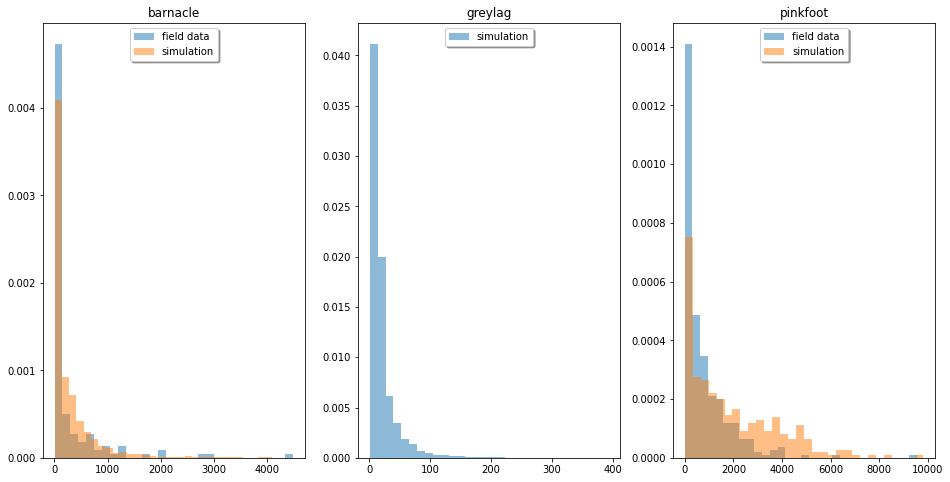

In [26]:
#forage_data=pd.read_csv(data_dir+"GooseFieldForageData.txt", sep='\t', header=0, dtype={'day': np.int16}, converters={'last_sown_veg': str.strip, 'veg_type_chr': str.strip, 'previous_crop': str.strip})
field_data = pd.read_csv(data_dir+"fieldobs_01112017.tsv", sep='\t', header=0, converters={'species':str.lower})
# The field dayordinal has the current day counting from 1/1/0001
#forage_data['dayordinal']=forage_data['day']+simulation_start_date_ordinal
# Useful function that parses the data 
#my_dateparser=(lambda x: pd.to_datetime(x,unit='D', origin=simulation_start_date))
# The field 'daydate includes the date of the day for the data'
#forage_data['daydate']=my_dateparser(forage_data['day'])
#forage_data['weekdate']=forage_data['daydate'].dt.strftime('%Y-W%U')
#forage_data_months_filtered = forage_data[forage_data['geese'+is_timed_str]&((forage_data['daydate'].dt.month>7) | (forage_data['daydate'].dt.month<4))]
fig3, ax3 = plt.subplots(1,3,figsize=mpl.figure.figaspect(0.5)*2)
for i in range(3):
    temp=forage_data_months_filtered[forage_data_months_filtered[species_names[i]+is_timed_str]>0][species_names[i]+is_timed_str]
    if species_names[i] != 'greylag':
        temp1 = field_data[field_data['species']==species_names[i]].numbers
        ax3[i].hist(temp1, label='field data', bins=30, alpha=0.5, density='True')
    ax3[i].hist(temp, label='simulation', bins=30, alpha=0.5, density='True')
    
    ax3[i].legend(fancybox=True, shadow=True,loc='upper center',bbox_to_anchor=(0.5, 1.0), ncol=1)
    ax3[i].set_title(species_names[i])